In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
import json

In [3]:
plt.style.use('seaborn-v0_8-pastel')

In [ ]:
with open('../config/lyft_conection.json', 'r') as file:
    credenciales_lyft = json.load(file)

In [ ]:

engine = create_engine(f"mysql+pymysql://{credenciales_lyft['USERNAME']}:{credenciales_lyft['PASSWORD']}@{credenciales_lyft['SERVER']}/{credenciales_lyft['DATABASE']}")

In [5]:
fecha_inicio = '2025-01-01 00:00:00'
fecha_fin = '2025-10-31 23:59:59'

In [8]:
sql_bike_payment_fact = f'''

SELECT 
    id,
    creationDateTime,
    amount,
    paymentType_id,
    paymentMode_id,
    creditCardType_id,
    completionDateTime,
    authorizationNumber,
    transactionId,
    creditCardId,
    cardBin,
    cardBinBrand,
    cardBinCountry,
    cardBinSubType,
    cardBinType,
    reasonCode,
    paymentSourceType_id
FROM BikePaymentFact
WHERE 
	creationDateTime BETWEEN UNIX_TIMESTAMP(CONVERT_TZ("{fecha_inicio}", "America/Mexico_City", 'UTC'))*1000
    AND UNIX_TIMESTAMP(CONVERT_TZ("{fecha_fin}", "America/Mexico_City", 'UTC'))*1000;

'''

df_sql_bike_payment_fact = pd.read_sql(sql_bike_payment_fact, engine)
df_sql_bike_payment_fact.head()

,id,creationDateTime,amount,paymentType_id,paymentMode_id,creditCardType_id,completionDateTime,authorizationNumber,transactionId,creditCardId,cardBin,cardBinBrand,cardBinCountry,cardBinSubType,cardBinType,reasonCode,paymentSourceType_id
0,6749899,1735711200135,0,6,6565653,2.0,1735711201086,None,7357112005986775004974,78ffda16-dfd5-43e8-a2a9-6cc9884eaacb,526354.0,MASTERCARD,USA,None,CREDIT,None,1
1,6749900,1735711201127,0,6,6565653,2.0,1735711201969,None,7357112015586817804980,3df8749d-4427-4fb1-9902-ad7d8b70b39d,554629.0,MASTERCARD,MEX,GOLD,CREDIT,None,1
2,6749901,1735711206672,5450000,0,6565653,2.0,1735711208245,None,7357112071096614704978,7ad3292d-002b-4a5a-b8b8-f952ea934351,549138.0,MASTERCARD,MEX,WORLD CARD,CREDIT,PROCESSOR_DECLINED,35
3,6749902,1735711208959,5450000,0,6565653,1.0,1735711210079,None,7357112094036033304987,b73acdd9-75bb-47e8-9be7-7937df66b30c,481516.0,VISA,MEX,None,CREDIT,INSUFFICIENT_FUND,35
4,6749903,1735711210962,5450000,0,6565653,1.0,1735711213191,None,7357112113846617604978,f239ca7a-38d5-4814-8002-5d4b8011930d,421316.0,VISA,MEX,CLASSIC,DEBIT,None,35


reasonCode
INSUFFICIENT_FUND                 32173
DECISION_PROFILE_REJECT           17162
UNAUTHORIZED_CARD                 14832
PROCESSOR_DECLINED                14168
PROCESSOR_ERROR                    4839
STOLEN_LOST_CARD                   4524
INVALID_ACCOUNT                    3813
ALLOWABLE_PIN_RETRIES_EXCEEDED     3111
EXPIRED_CARD                       2089
CONTACT_PROCESSOR                   995
EXCEEDS_CREDIT_LIMIT                152
INVALID_CVN                         105
CV_FAILED                            23
GENERAL_DECLINE                       4
Name: count, dtype: int64


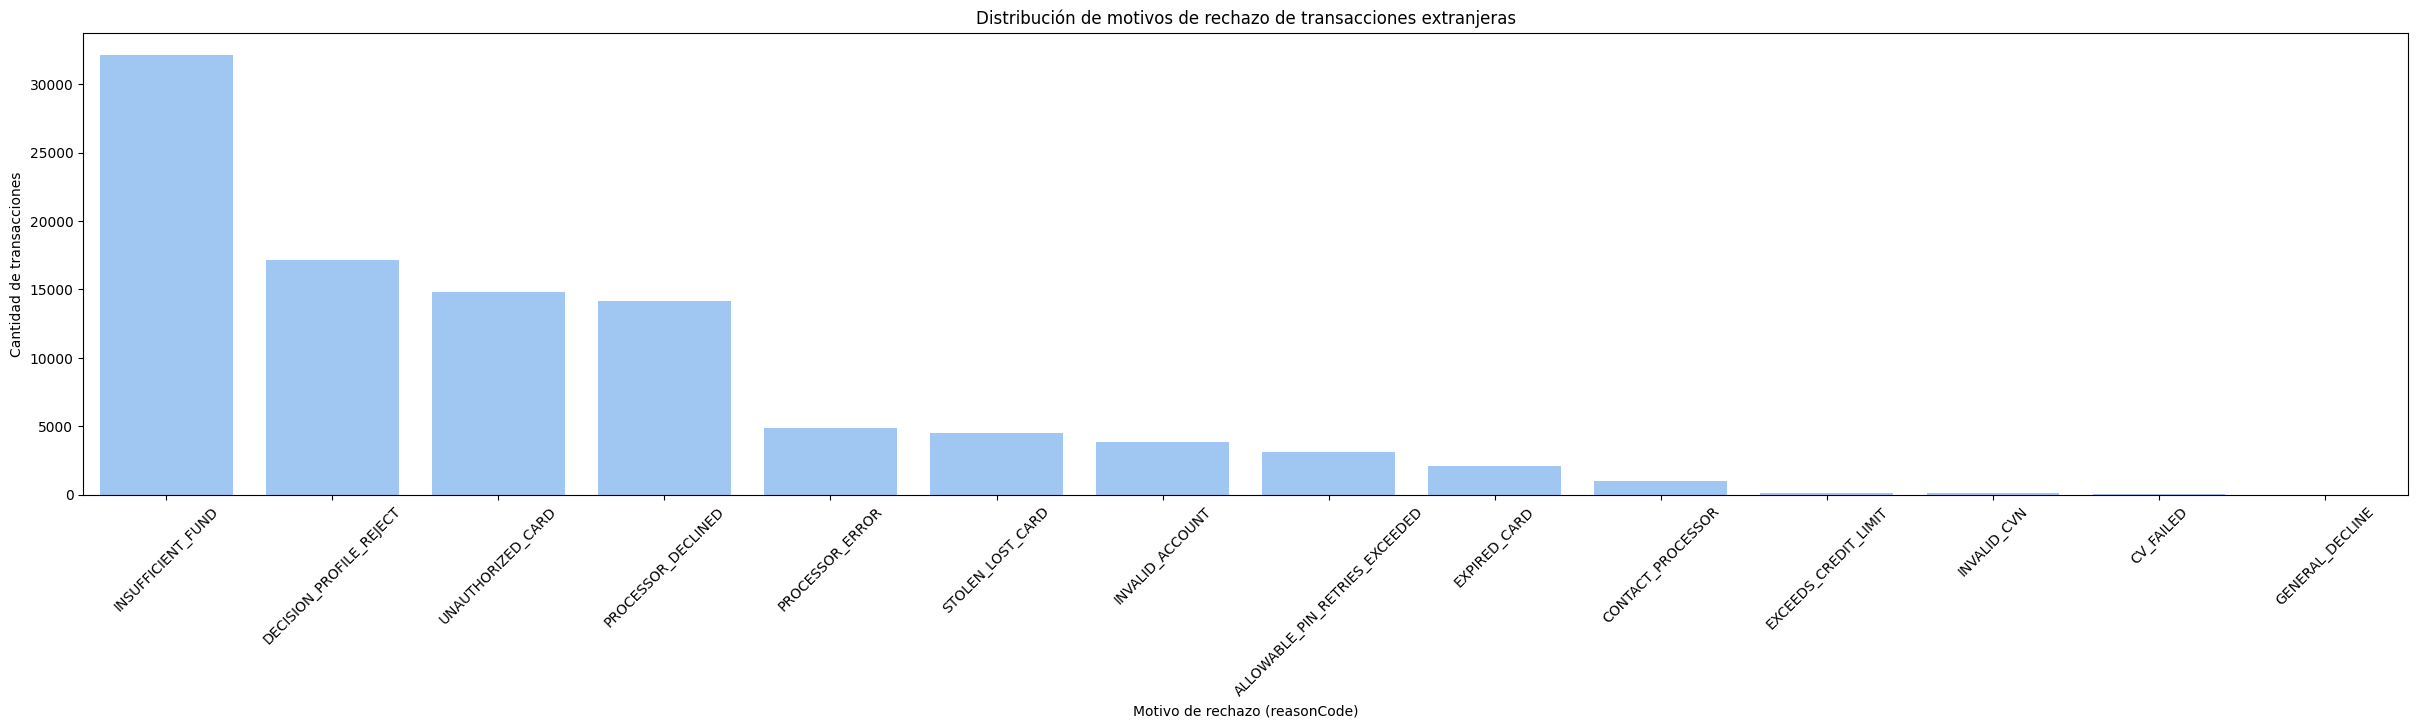

In [28]:
# filtrar donde cardBinCountry != 'MEX'
df_sql_bike_payment_fact_foreign = df_sql_bike_payment_fact[df_sql_bike_payment_fact['cardBinCountry'] != 'MEX']

print(df_sql_bike_payment_fact_foreign['reasonCode'].value_counts())
# grafica de barras de reasonCode
plt.figure(figsize=(30,6))
sns.countplot(data=df_sql_bike_payment_fact_foreign, x='reasonCode', order=df_sql_bike_payment_fact_foreign['reasonCode'].value_counts().index)
plt.title('Distribución de motivos de rechazo de transacciones extranjeras')
plt.xlabel('Motivo de rechazo (reasonCode)')
plt.ylabel('Cantidad de transacciones')
plt.xticks(rotation=45)
plt.show()

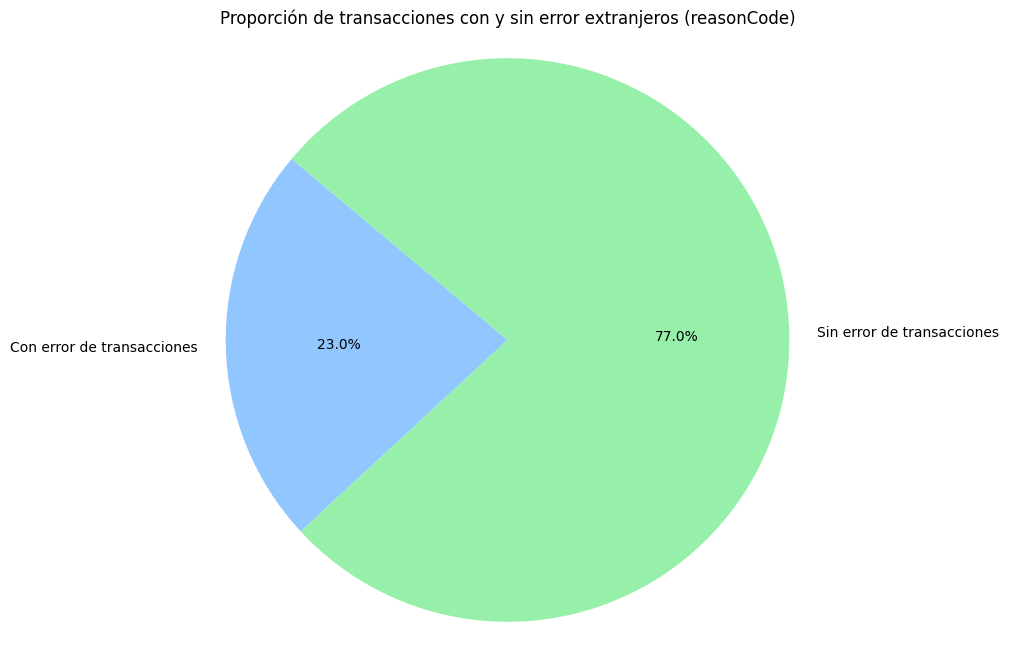

In [25]:
# grafica de de pastel reasonCode vacio vs no vacio

labels = ['Con error de transacciones', 'Sin error de transacciones']
sizes = [df_sql_bike_payment_fact_foreign['reasonCode'].notnull().sum(), df_sql_bike_payment_fact_foreign['reasonCode'].isnull().sum()]
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Proporción de transacciones con y sin error extranjeros (reasonCode)')
plt.axis('equal')
plt.show()

In [42]:
df_sql_bike_payment_fact_foreign.count()

id                      426104
creationDateTime        426104
amount                  426104
paymentType_id          426104
paymentMode_id          426104
creditCardType_id       425933
completionDateTime      426104
authorizationNumber          0
transactionId           291894
creditCardId            425933
cardBin                 425933
cardBinBrand            425149
cardBinCountry          424305
cardBinSubType          226544
cardBinType             425149
reasonCode               97990
paymentSourceType_id    426104
reasonCodeCategory      426104
dtype: int64

In [29]:
# calcular tasa de error de transacciones extranjeras
total_foreign_transactions = len(df_sql_bike_payment_fact_foreign)
error_transactions = df_sql_bike_payment_fact_foreign['reasonCode'].notnull().sum()
tasa_error = (error_transactions / total_foreign_transactions) * 100
print(f'Tasa de error de transacciones extranjeras: {tasa_error:.2f}%')


Tasa de error de transacciones extranjeras: 23.00%


In [30]:
# calcular Tasa de procesamiento exitoso
total_transactions = len(df_sql_bike_payment_fact)
successful_transactions = df_sql_bike_payment_fact['reasonCode'].isnull().sum()
tasa_exito = (successful_transactions / total_transactions) * 100
print(f'Tasa de procesamiento exitoso: {tasa_exito:.2f}%')

Tasa de procesamiento exitoso: 70.04%


In [34]:
# Total del monto de transacciones fallidas
total_failed_amount = df_sql_bike_payment_fact_foreign[df_sql_bike_payment_fact_foreign['reasonCode'].notnull()]['amount'].sum()
print(f'Total del monto de transacciones fallidas extranjeras: {total_failed_amount/10000}')


Total del monto de transacciones fallidas extranjeras: 35369230.49
